# Visualizing particle trajectories at the bathymetric jump

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc

from oceantracker.post_processing.read_output_files import load_output_files 
from oceantracker.util.polygon_util import InsidePolygon
from oceantracker.post_processing.transect_projection.transect import Transect
from oceantracker.post_processing.plotting import plot_transects
from oceantracker.post_processing.plotting import plot_utilities

from matplotlib.animation import FuncAnimation

In [5]:
transect_polygone = [
    {'points':
        np.array([
            [569979,5930284],
            [570239,5930483],
            [569147,5931534],
            [568979,5931251]
        ])
    },
    {'points':
        np.array([
            [568988,5931254],
            [569147,5931537],
            [567622,5932312],
            [567502,5932043]
        ])
    },
    {'points':
        np.array([
            [567584,5931996],
            [567704,5932265],
            [565924,5932656],
            [565900,5932289]
        ])
    },
    {'points':
        np.array([
            [565900,5932282],
            [565943,5932663],
            [564086,5933401],
            [563971,5933043]
        ])
    },
    {'points':
        np.array([
            [564000,5933064],
            [564096,5933417],
            [562586,5933178],
            [562643,5932757]
        ])
    },
    {'points':
        np.array([
            [562638,5932757],
            [562614,5933141],
            # [561359,5933128],
            # [561359,5932690]
            [560000,5933128],
            [560000,5932690]
        ])
    }
]

transect_planes = [
    {'points':
        np.array([
            [570181,5930237],
            [568926,5931456]
        ])
    },
    {'points':
        np.array([
            [569123,5931325],
            [567444,5932218]
        ])
    },
    {'points':
        np.array([
            [567771,5932080],
            [565804,5932477]
        ])
    },
    {'points':
        np.array([
            [565977,5932423],
            [563961,5933259]
        ])
    },
    {'points':
        np.array([
            [564207,5933266],
            [562446,5932925]
        ])
    },
    {'points':
        np.array([
            [562704,5932919],
            [560000,5932947]
        ])
    }
]

In [6]:
transect = [{'polygon_vertices': poly['points'],'plane_vertices': plane['points']} for poly,plane in zip(transect_polygone,transect_planes)]

## RUN

In [7]:
def animate_full_transect(tracks, transect, t_min=0, t_duration=None, plot_file_name=None, axis_lims_map=None, axis_lims_transect_h=None, axis_lims_transect_v=None):
    """
    Creates three subplots:
    - horizontal tracks on the unprojected model domain
    - vertical tracks on the projected model domain
    - horizontal tracks on the projected model domain
    """

    def update(nt):
        ax[0].clear()
        ax[1].clear()

        x = transect.track_data['x']
        # # only look at those currently being alive
        # # alive = transect.track_data['status'] > 0
        # # x = x[nt, alive[nt], : ]

        particles_in_transect = ~np.isnan(x[nt, :, 0])
        x = x[nt, particles_in_transect, :]
        depth = transect.track_data['water_depth'][nt, particles_in_transect]
        water_level = transect.track_data['tide'][nt, particles_in_transect]


        ## MAP
        tri01 = ax[0].tripcolor(transect.track_data['grid']['x'][:,0],
                    transect.track_data['grid']['x'][:,1],
                    transect.track_data['grid']['water_depth'],
                    triangles=transect.track_data['grid']['triangles'],
                    shading='gouraud', cmap='Blues', edgecolors='none', zorder=1)

        scatter01 = ax[0].scatter(tracks['x'][nt, particles_in_transect, 0], tracks['x'][nt, particles_in_transect, 1], c=np.arange(tracks['x'][:,particles_in_transect,:].shape[1]) % 20)


        ## VERTICAL TRANSECT
        # particle
        scatter21 = ax[1].scatter(x[:, 0], x[:, 2], c=np.arange(x.shape[0]) % 20)
        # bottom at particle location
        scatter22 = ax[1].scatter(x[:, 0], -depth, marker='_', c=np.arange(x.shape[0]) % 20)
        # water level at particle location
        scatter23 = ax[1].scatter(x[:, 0], water_level, marker='_', c=np.arange(x.shape[0]) % 20)
        # line from water level to bottom set behing the particle scatter plot
        lines20 = ax[1].vlines(x[:, 0], -depth, water_level, alpha=0.5)
        # ax[0].set_title(f'verticle tracks at timestep {transect.track_data["time"][nt].astype("datetime64[s]")}')

        ## AXIS LIMS   
        ax[0].set_title(f'map at timestep {transect.track_data["time"][nt].astype("datetime64[s]")}')

        ax[0].set_title(f'position in transect at timestep {transect.track_data["time"][nt].astype("datetime64[s]")}')
        ax[1].set_xlabel('distance downstream [m]')
        ax[1].set_ylabel('depth [m]')
        # swap orientation of x axis
        
        ax[1].set_xlim((0, transect.transect[-1]['length'] + transect.transect[-1]['distance_downstream']))
        ax[1].invert_xaxis()

        if axis_lims_map is not None:
            ax[0].set_xlim(axis_lims_map[:2])
            ax[0].set_ylim(axis_lims_map[2:])
        if axis_lims_transect_v is not None:
            ax[1].set_ylim(axis_lims_transect_v[2:])   

        return scatter01, scatter21, scatter22, scatter23, lines20
    

    fig, ax = plt.subplots(2,1,figsize=(10,15),dpi=100)

    ani = FuncAnimation(fig, update,
                        frames=range(t_min, t_min + (t_duration if t_duration else len(transect.track_data['x']) - t_min)),
                        blit=True)

    if plot_file_name is not None:
        ani.save(plot_file_name, writer='ffmpeg', fps=10)
    else:
        plt.show()


### v04

In [8]:
path_to_dir = '/scratch/local1/output/23_08_17_bath_jump_traj_v04'
cases = load_output_files.get_case_info_files_from_dir(path_to_dir)

tracks = load_output_files.load_particle_track_vars(cases[0], var_list=['tide','water_depth'])

norderelbe_transect = Transect(transect)
norderelbe_transect.project_track_data(path_to_dir,var_list=['water_depth','age','tide'],n_case=0)

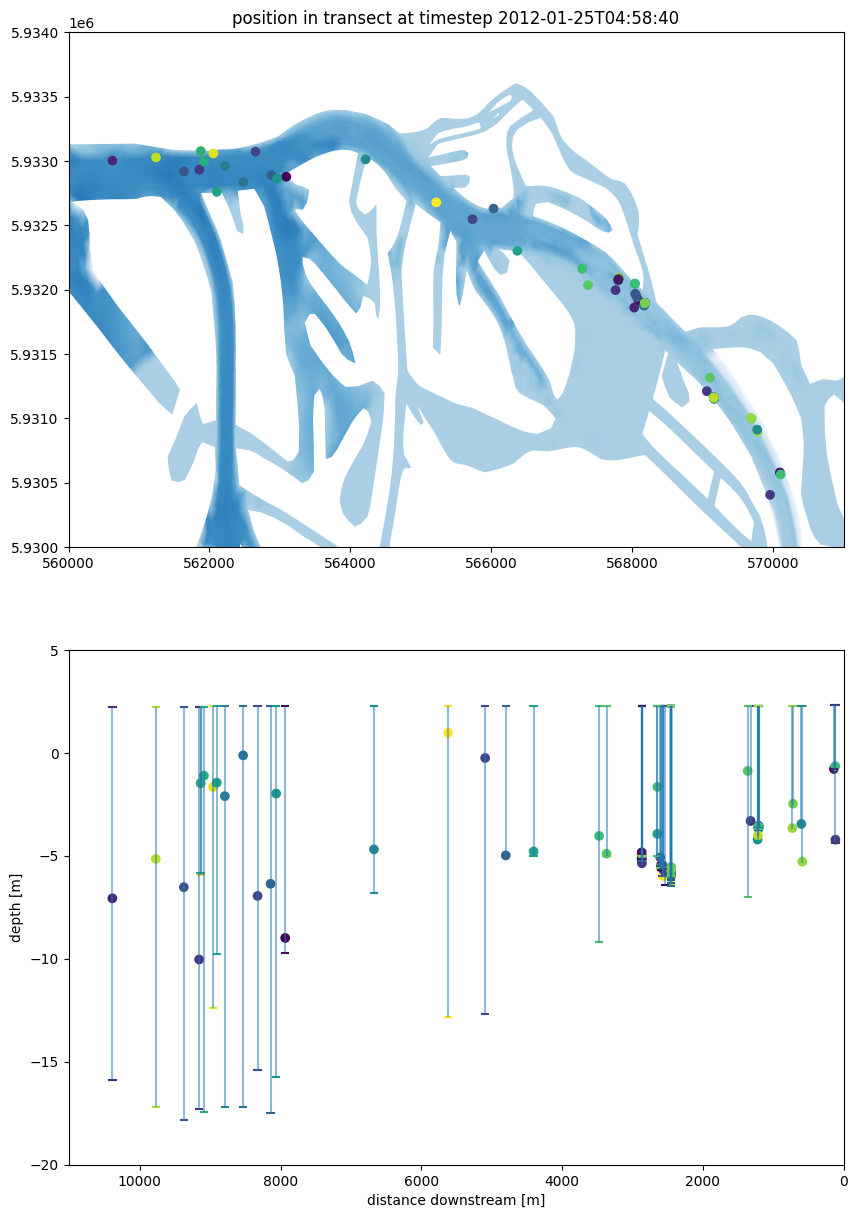

In [10]:
animate_full_transect(tracks, norderelbe_transect, 
                      t_min=25000, t_duration=1100, 
                      plot_file_name='map_n_vertical_summer_neutral_tmp.mp4',
                      axis_lims_map=[560000, 571000, 5930000, 5934000],
                      axis_lims_transect_v=[0,10000,-20,5])

### v02

In [7]:
path_to_dir = '/scratch/local1/output/23_08_17_bath_jump_traj_v02'
cases = load_output_files.get_case_info_files_from_dir(path_to_dir)

tracks = load_output_files.load_particle_track_vars(cases[0], var_list=['tide','water_depth'])

norderelbe_transect = Transect(transect)
norderelbe_transect.project_track_data(path_to_dir,var_list=['water_depth','age','tide'],n_case=0)

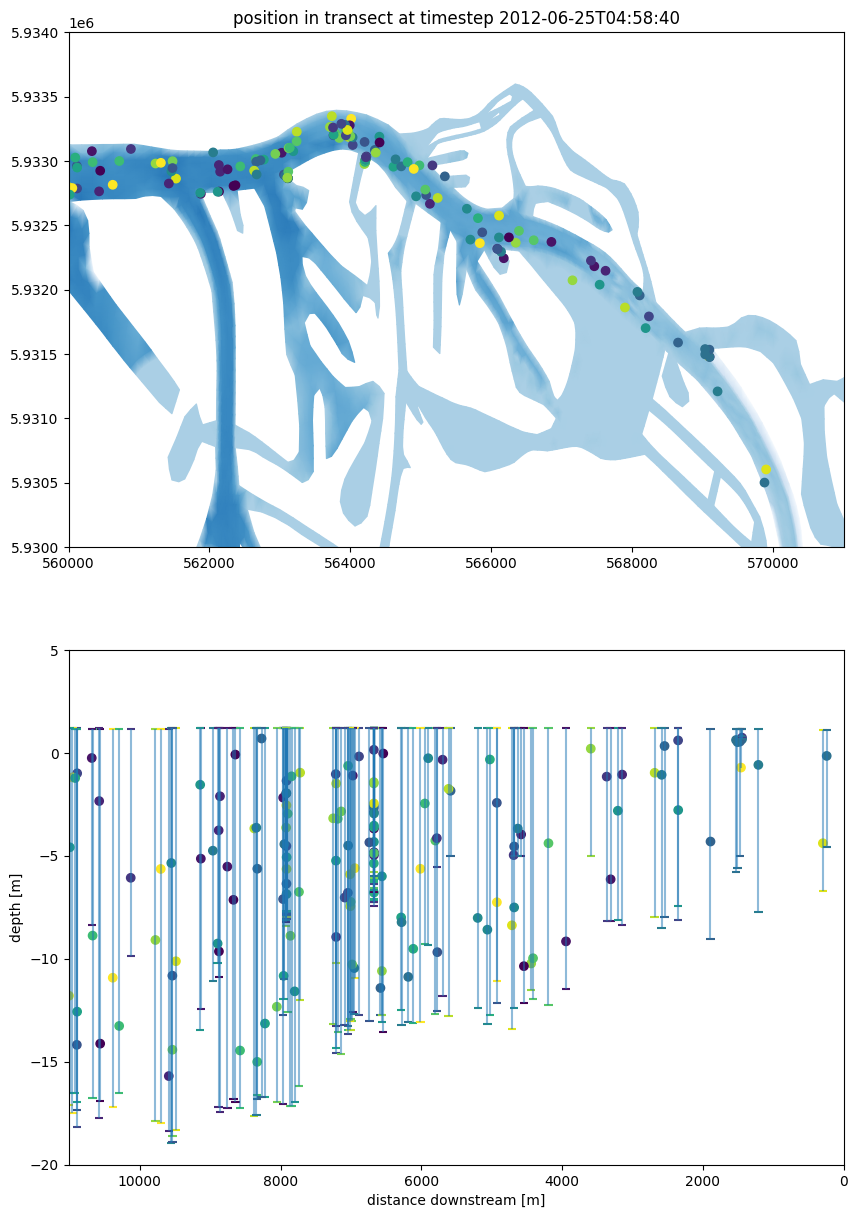

In [19]:
animate_full_transect(tracks, norderelbe_transect, 
                      t_min=25000, t_duration=1100, 
                      plot_file_name='map_n_vertical_summer_neutral_tmp.mp4',
                      axis_lims_map=[560000, 571000, 5930000, 5934000],
                      axis_lims_transect_v=[0,10000,-20,5])

### v00

In [20]:
path_to_dir = '/scratch/local1/output/23_08_17_bath_jump_traj_v00'
cases = load_output_files.get_case_info_files_from_dir(path_to_dir)

tracks = load_output_files.load_particle_track_vars(cases[0], var_list=['tide','water_depth'])

norderelbe_transect = Transect(transect)
norderelbe_transect.project_track_data(path_to_dir,var_list=['water_depth','age','tide'],n_case=0)

: 

: 

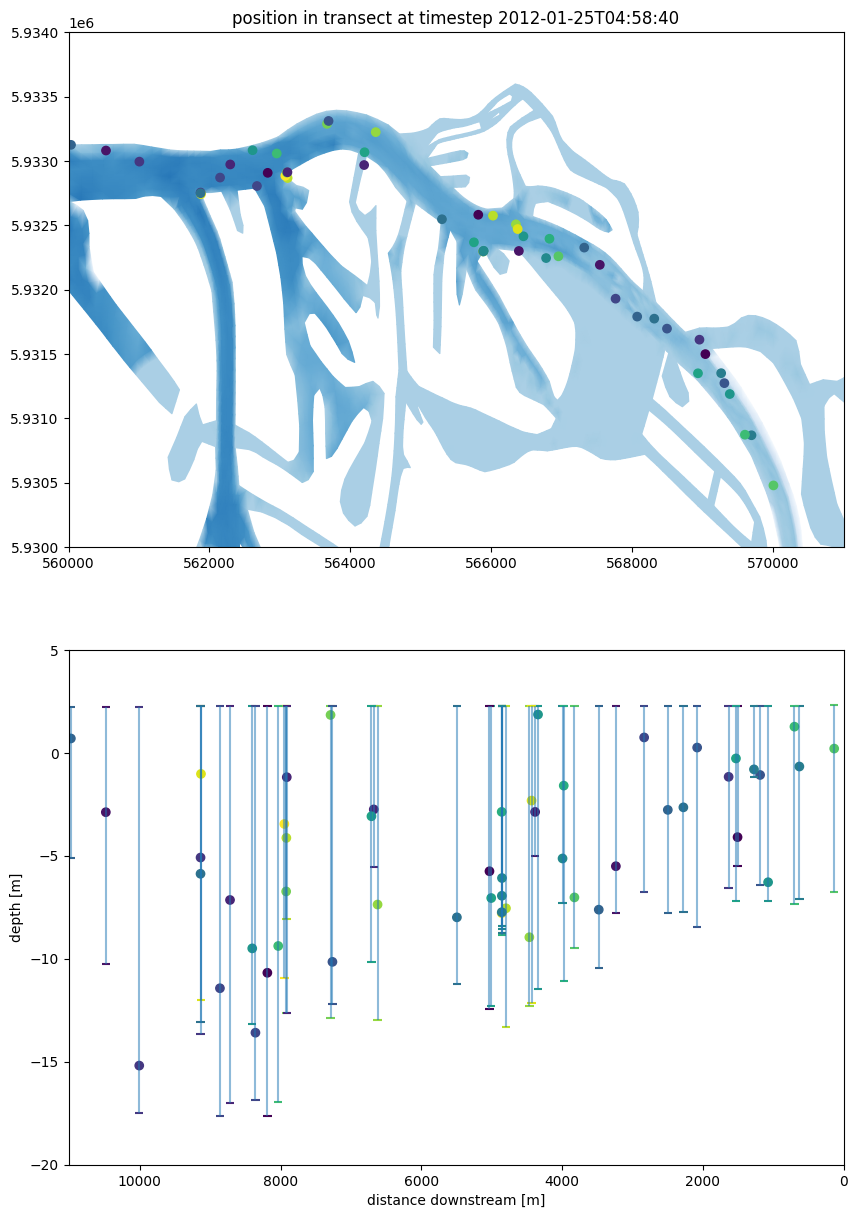

In [6]:
animate_full_transect(tracks, norderelbe_transect, 
                      t_min=25000, t_duration=1100, 
                      plot_file_name='map_n_vertical_winter_neutral.mp4',
                      axis_lims_map=[560000, 571000, 5930000, 5934000],
                      axis_lims_transect_v=[0,10000,-20,5])

### v01

In [5]:
path_to_dir = '/scratch/local1/output/23_08_17_bath_jump_traj_v01'
cases = load_output_files.get_case_info_files_from_dir(path_to_dir)

tracks = load_output_files.load_particle_track_vars(cases[0], var_list=['tide','water_depth'])

norderelbe_transect = Transect(transect)
norderelbe_transect.project_track_data(path_to_dir,var_list=['water_depth','age','tide'],n_case=0)

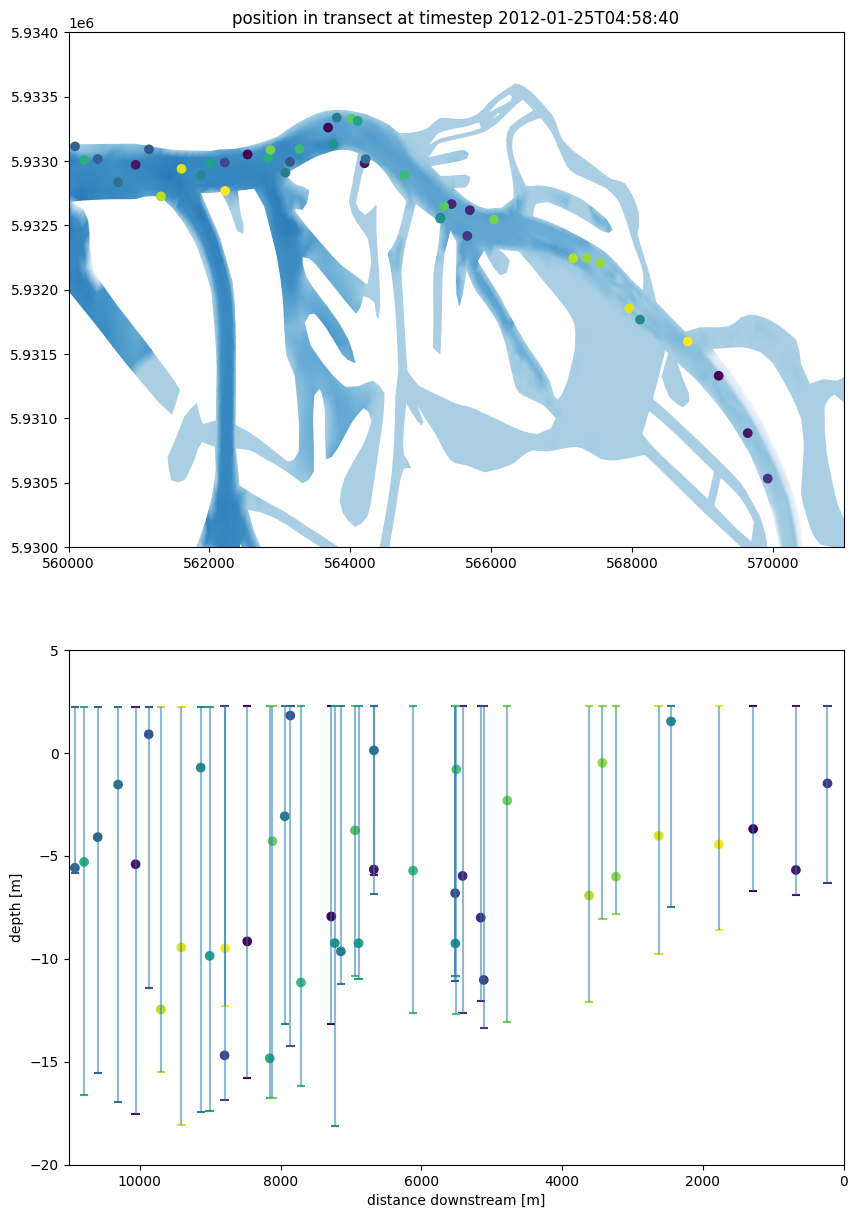

In [6]:
animate_full_transect(tracks, norderelbe_transect, 
                      t_min=25000, t_duration=1100, 
                      plot_file_name='map_n_vertical_winter_sinking.mp4',
                      axis_lims_map=[560000, 571000, 5930000, 5934000],
                      axis_lims_transect_v=[0,10000,-20,5])

### v03

In [4]:
path_to_dir = '/scratch/local1/output/23_08_17_bath_jump_traj_v03'
cases = load_output_files.get_case_info_files_from_dir(path_to_dir)

tracks = load_output_files.load_particle_track_vars(cases[0], var_list=['tide','water_depth'])

norderelbe_transect = Transect(transect)
norderelbe_transect.project_track_data(path_to_dir,var_list=['water_depth','age','tide'],n_case=0)

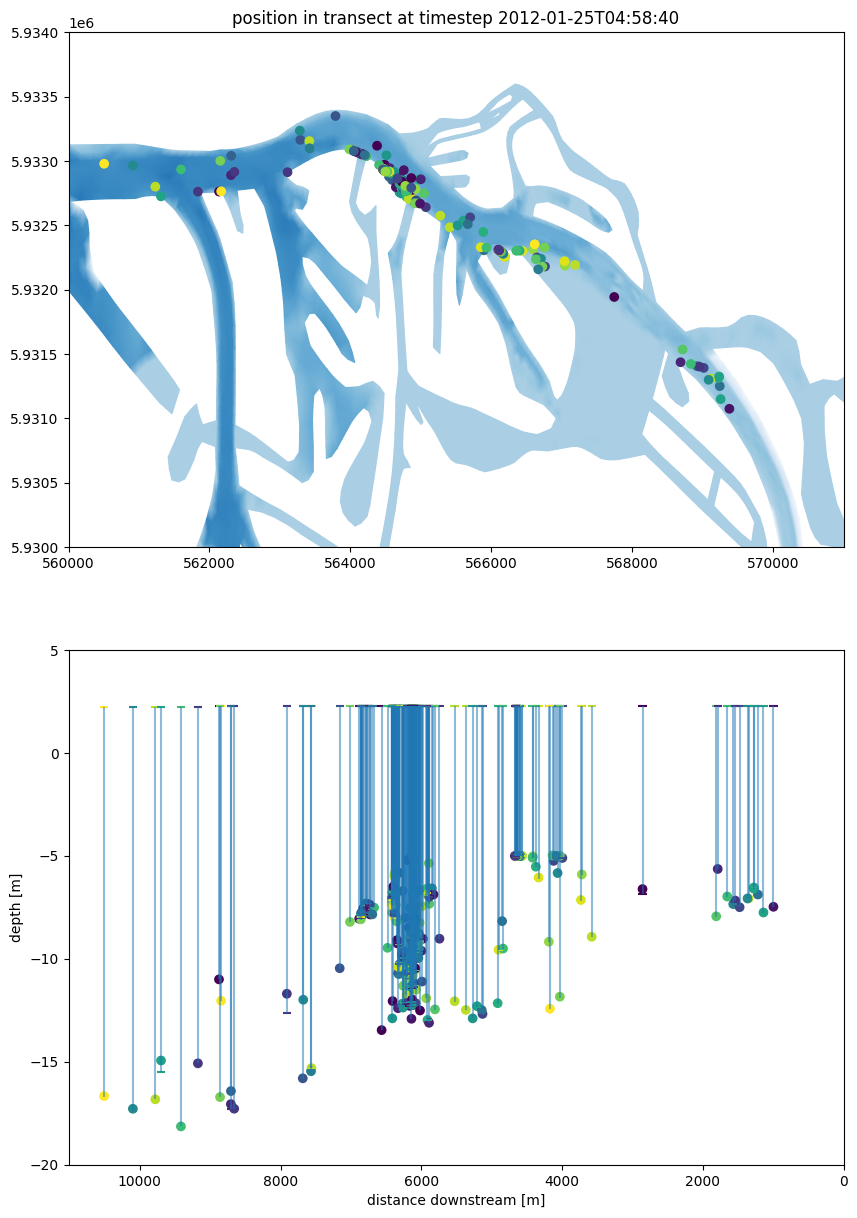

In [7]:
animate_full_transect(tracks, norderelbe_transect, 
                      t_min=25000, t_duration=1100, 
                      plot_file_name='map_n_vertical_winter_strong_sinking.mp4',
                      axis_lims_map=[560000, 571000, 5930000, 5934000],
                      axis_lims_transect_v=[0,10000,-20,5])

## DEV

In [4]:
path_to_dir = '/scratch/local1/output/23_08_17_bath_jump_traj_v00'
cases = load_output_files.get_case_info_files_from_dir(path_to_dir)

tracks = load_output_files.load_particle_track_vars(cases[0], var_list=['tide','water_depth'])

norderelbe_transect = Transect(transect)
norderelbe_transect.project_track_data(path_to_dir,var_list=['water_depth','age','tide'],n_case=0)

In [5]:
# transform posix time into date time
time = norderelbe_transect.track_data['time'].astype('datetime64[s]')
time[1] - time[0]

numpy.timedelta64(80,'s')

(<Figure size 640x480 with 2 Axes>, <AxesSubplot:>)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
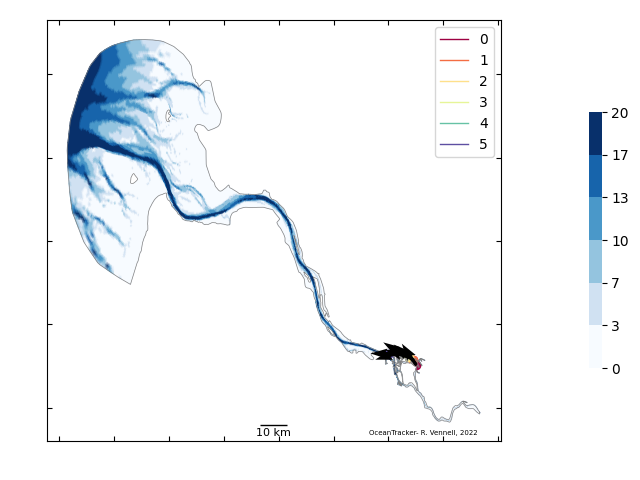

In [8]:
%matplotlib widget
from oceantracker.post_processing.plotting import plot_transects

plot_transects.plot_transect_map(norderelbe_transect)

In [7]:
def plot_projected_verticle_tracks(transect,nt=0,plot_file_name=None,axis_lims=None):
    
    x = transect.track_data['x']
   
    particles_in_transect = ~np.isnan(x[nt,:,0])

    x = x[nt,particles_in_transect] #downstream
    z = transect.track_data['z'][nt,particles_in_transect]
    depth = transect.track_data['water_depth'][nt,particles_in_transect]

    plt.figure()
    # plot scatter with a different color for each particle using a set of 20 colors
    plt.scatter(x[:,0],x[:,2],c=np.arange(x.shape[0])%20)
    # use the same colors for the depth markers
    plt.scatter(x[:,0],-depth,marker='_',c=np.arange(x.shape[0])%20)
    # add a vertical line between the scatter and the depth markers
    plt.vlines(x[:,0],-depth,x[:,2],alpha=0.5)

    plt.xlim((0,transect.transect[-1]['length'] + transect.transect[-1]['distance_downstream']))

    # set title with date time of the current timestep
    plt.title(f'verticle tracks at timestep {transect.track_data["time"][nt].astype("datetime64[s]")}')
    plt.xlabel('distance downstream [m]')
    plt.ylabel('depth [m]')
    
    if axis_lims is not None:
        plt.xlim(axis_lims[:2])
        plt.xlim(axis_lims[2:])

    if plot_file_name is not None:
        plt.savefig(plot_file_name,dpi=300)

In [8]:
def animate_projected_verticle_tracks(transect, t_min=0, t_duration=None, plot_file_name=None, axis_lims=None):

    def update(nt):
        ax.clear()

        x = transect.track_data['x']
        # only look at those currently being alive
        # alive = transect.track_data['status'] > 0
        # x = x[nt, alive[nt], : ]

        particles_in_transect = ~np.isnan(x[nt, :, 0])
        x = x[nt, particles_in_transect, :]
        z = transect.track_data['z'][nt, particles_in_transect]
        depth = transect.track_data['water_depth'][nt, particles_in_transect]
        water_level = transect.track_data['tide'][nt, particles_in_transect]

        # particle
        scatter1 = ax.scatter(x[:, 0], x[:, 2], c=np.arange(x.shape[0]) % 20)
        # bottom at particle location
        scatter2 = ax.scatter(x[:, 0], -depth, marker='_', c=np.arange(x.shape[0]) % 20)
        # water level at particle location
        scatter3 = ax.scatter(x[:, 0], water_level, marker='_', c=np.arange(x.shape[0]) % 20)
        # line from water level to bottom set behing the particle scatter plot
        lines = ax.vlines(x[:, 0], -depth, water_level, alpha=0.5)

        ax.set_xlim((0, transect.transect[-1]['length'] + transect.transect[-1]['distance_downstream']))
        ax.set_title(f'verticle tracks at timestep {transect.track_data["time"][nt].astype("datetime64[s]")}')
        ax.set_xlabel('distance downstream [m]')
        ax.set_ylabel('depth [m]')

        if axis_lims is not None:
            ax.set_xlim(axis_lims[:2])
            ax.set_ylim(axis_lims[2:])

        return scatter1, scatter2, scatter3, lines

    fig, ax = plt.subplots()

    ani = FuncAnimation(fig, update,
                        frames=range(t_min, t_min + (t_duration if t_duration else len(transect.track_data['x']) - t_min)),
                        blit=True)

    if plot_file_name:
        ani.save(plot_file_name, writer='ffmpeg', fps=5)
    else:
        plt.show()


In [10]:
def plot_horizontal_transect(transect, nt = 0):
    
    fig, ax = plt.subplots()

    x = transect.track_data['x']
    # only look at those currently being alive
    # alive = transect.track_data['status'] > 0
    # x = x[nt, alive[nt], : ]

    particles_in_transect = ~np.isnan(x[nt, :, 0])
    x = x[nt, particles_in_transect, :]
    depth = transect.track_data['water_depth'][nt, particles_in_transect]
    water_level = transect.track_data['tide'][nt, particles_in_transect]

    # particle
    scatter1 = ax.scatter(x[:, 0], x[:, 1], c=np.arange(x.shape[0]) % 20)
    # # bottom at particle location
    # scatter2 = ax.scatter(x[:, 0], -depth, marker='_', c=np.arange(x.shape[0]) % 20)
    # # water level at particle location
    # scatter3 = ax.scatter(x[:, 0], water_level, marker='_', c=np.arange(x.shape[0]) % 20)
    # # line from water level to bottom set behing the particle scatter plot
    # lines = ax.vlines(x[:, 0], -depth, water_level, alpha=0.5)

    ax.set_xlim((0, transect.transect[-1]['length'] + transect.transect[-1]['distance_downstream']))
    ax.set_title(f'horizontal tracks at timestep {transect.track_data["time"][nt].astype("datetime64[s]")}')
    ax.set_xlabel('distance downstream [m]')
    ax.set_ylabel('distance off transect [m]')




In [11]:
def animate_projected_horizontal_tracks(transect, t_min=0, t_duration=None, plot_file_name=None, axis_lims=None):

    def update(nt):
        ax.clear()

        x = transect.track_data['x']
        # only look at those currently being alive
        # alive = transect.track_data['status'] > 0
        # x = x[nt, alive[nt], : ]

        particles_in_transect = ~np.isnan(x[nt, :, 0])
        x = x[nt, particles_in_transect, :]
        depth = transect.track_data['water_depth'][nt, particles_in_transect]
        water_level = transect.track_data['tide'][nt, particles_in_transect]

        # particle
        scatter1 = ax.scatter(x[:, 0], x[:, 1], c=np.arange(x.shape[0]) % 20)
        # # bottom at particle location
        # scatter2 = ax.scatter(x[:, 0], -depth, marker='_', c=np.arange(x.shape[0]) % 20)
        # # water level at particle location
        # scatter3 = ax.scatter(x[:, 0], water_level, marker='_', c=np.arange(x.shape[0]) % 20)
        # # line from water level to bottom set behing the particle scatter plot
        # lines = ax.vlines(x[:, 0], -depth, water_level, alpha=0.5)

        ax.set_xlim((0, transect.transect[-1]['length'] + transect.transect[-1]['distance_downstream']))
        ax.set_title(f'horizontal tracks at timestep {transect.track_data["time"][nt].astype("datetime64[s]")}')
        ax.set_xlabel('distance downstream [m]')
        ax.set_ylabel('distance off transect [m]')

        if axis_lims is not None:
            ax.set_xlim(axis_lims[:2])
            ax.set_ylim(axis_lims[2:])


        return scatter1, # scatter2, scatter3, lines

    fig, ax = plt.subplots()

    ani = FuncAnimation(fig, update,
                        frames=range(t_min, t_min + (t_duration if t_duration else len(transect.track_data['x']) - t_min)),
                        blit=True)

    if plot_file_name:
        ani.save(plot_file_name, writer='ffmpeg', fps=5)
    else:
        plt.show()


In [6]:
def animate_full_transect(tracks, transect, t_min=0, t_duration=None, plot_file_name=None, axis_lims_map=None, axis_lims_transect_h=None, axis_lims_transect_v=None):
    """
    Creates three subplots:
    - horizontal tracks on the unprojected model domain
    - vertical tracks on the projected model domain
    - horizontal tracks on the projected model domain
    """

    def update(nt):
        ax[0].clear()
        ax[1].clear()

        x = transect.track_data['x']
        # # only look at those currently being alive
        # # alive = transect.track_data['status'] > 0
        # # x = x[nt, alive[nt], : ]

        particles_in_transect = ~np.isnan(x[nt, :, 0])
        x = x[nt, particles_in_transect, :]
        depth = transect.track_data['water_depth'][nt, particles_in_transect]
        water_level = transect.track_data['tide'][nt, particles_in_transect]


        ## MAP
        tri01 = ax[0].tripcolor(transect.track_data['grid']['x'][:,0],
                    transect.track_data['grid']['x'][:,1],
                    transect.track_data['grid']['water_depth'],
                    triangles=transect.track_data['grid']['triangles'],
                    shading='gouraud', cmap='Blues', edgecolors='none', zorder=1)

        scatter01 = ax[0].scatter(tracks['x'][nt, particles_in_transect, 0], tracks['x'][nt, particles_in_transect, 1], c=np.arange(tracks['x'][:,particles_in_transect,:].shape[1]) % 20)


        ## VERTICAL TRANSECT
        # particle
        scatter21 = ax[1].scatter(x[:, 0], x[:, 2], c=np.arange(x.shape[0]) % 20)
        # bottom at particle location
        scatter22 = ax[1].scatter(x[:, 0], -depth, marker='_', c=np.arange(x.shape[0]) % 20)
        # water level at particle location
        scatter23 = ax[1].scatter(x[:, 0], water_level, marker='_', c=np.arange(x.shape[0]) % 20)
        # line from water level to bottom set behing the particle scatter plot
        lines20 = ax[1].vlines(x[:, 0], -depth, water_level, alpha=0.5)
        # ax[0].set_title(f'verticle tracks at timestep {transect.track_data["time"][nt].astype("datetime64[s]")}')

        ## AXIS LIMS   
        ax[0].set_title(f'map at timestep {transect.track_data["time"][nt].astype("datetime64[s]")}')

        ax[0].set_title(f'position in transect at timestep {transect.track_data["time"][nt].astype("datetime64[s]")}')
        ax[1].set_xlabel('distance downstream [m]')
        ax[1].set_ylabel('depth [m]')
        # swap orientation of x axis
        
        ax[1].set_xlim((0, transect.transect[-1]['length'] + transect.transect[-1]['distance_downstream']))
        ax[1].invert_xaxis()

        if axis_lims_map is not None:
            ax[0].set_xlim(axis_lims_map[:2])
            ax[0].set_ylim(axis_lims_map[2:])
        if axis_lims_transect_v is not None:
            ax[1].set_ylim(axis_lims_transect_v[2:])   

        return scatter01, scatter21, scatter22, scatter23, lines20
    

    fig, ax = plt.subplots(2,1,figsize=(10,15),dpi=100)

    ani = FuncAnimation(fig, update,
                        frames=range(t_min, t_min + (t_duration if t_duration else len(transect.track_data['x']) - t_min)),
                        blit=True)

    if plot_file_name is not None:
        ani.save(plot_file_name, writer='ffmpeg', fps=10)
    else:
        plt.show()
